<a href="https://colab.research.google.com/github/lorenzflow/Portfolio/blob/main/Clothing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classification of clothing items
We will analyse the data set of clothing images and train unsupervised as well as supervised classifiers and discuss the differences in performance.
- unsupervised clustering is performed via kmeans and classification via knn
- supervised clustering with a neural network and convolutional neural network in PyTorch.

### 1.1

In [ ]:
# importing data
fashion_train = pd.read_csv("/content/drive/My Drive/Data Science Coursework 3/fashion_train.csv")
fashion_test = pd.read_csv("/content/drive/My Drive/Data Science Coursework 3/fashion_test.csv")

In [ ]:
fashion_train.shape

(60000, 785)

In [ ]:
# quick inspection shows that first column is label
fashion_train.iloc[:,0].unique()

# extract labels so get X and y
y_train = fashion_train.iloc[:,0]
y_test = fashion_test.iloc[:,0]
X_train = fashion_train.drop(fashion_train.columns[0], axis=1)
X_test = fashion_test.drop(fashion_test.columns[0], axis=1)

#### Kmeans Clustering

In [ ]:
# clustering with kmeans. Store labels to later compute the different scores
kmeans_output = []
inertia_list = []

for k in range(2,31):
  kmeans = KMeans(n_clusters=k, init='k-means++', n_init=20, max_iter=300, tol=0.0001, verbose=0, random_state=10, n_jobs=-1)
  kmeans_output.append(kmeans.fit_predict(X_train))
  inertia_list.append(kmeans.inertia_)
  print(k)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


The randomness introduced into the output of the k-means algorithm is inherited from the initialisation of the centroids, which originally is done randomly.

For an efficient algorithm we would want to position the centroids as close to the optimum as possible to ensure quick convergence and good clustering.

If we randomly initialise bad centroids our algorithm might not converge within the set number of maximal iterations. We could fight this by increasing the number of iterations but in some cases this won't help. Furthermore we might only converge to very local minima.

An option to control this randomness would be to manually initialise the centroids. However, if we do not have knowledge of the hyperplane, we might choose bad initial centroids and will never find a good clustering. 

A far better option is to initialise n different sets of centroids, run the algorithm n times, and then choose the best result in terms of inertia. This only is an attempt to control randomness by quantity and is computationally more expensive since we run the algorithm n times, but can increase the performance of the algorithm drastically. To deal with the randomness I have increased the corresponding parameter n_iter to 20.

Furthermore the python implementation allows for the initialisation option 'kmeans++'. This algorithm chooses the first centroid randomly from the data points and then assigns probabilities of being chosen as next centroid to the other data points based on their distance to the first centroid. That way we are more likely to end up with centroids that are further appart. A remaining problem is the possible existence of outliers in the data set.

#### Do we find support for there being 10 classes?
We will first have a look at the Davies Boulding, Silhouette, and Calinski Harabasz scores and the inertia of the k-means clusterings. 

We will 

In [ ]:
counter = 0
db_score_2 = []
sc_score_2 = []
ch_score_2 = []
for i in kmeans_output:
  db_score_2.append(davies_bouldin_score(X_train, i))
  sc_score_2.append(silhouette_score(X_train,i))
  ch_score_2.append(calinski_harabasz_score(X_train,i))
  counter = counter+1
  print(counter)
  

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


Text(0, 0.5, 'Inertia')

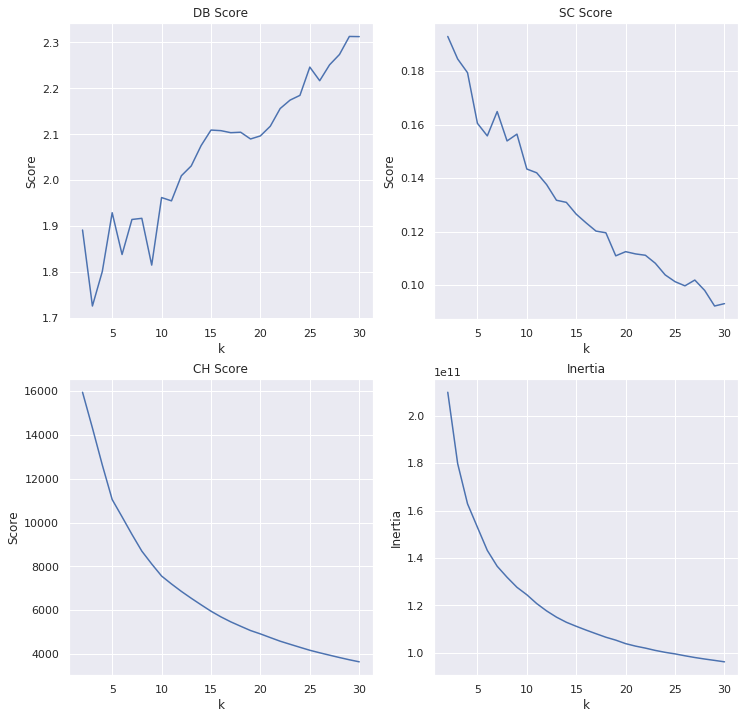

In [ ]:
# plot metrics of k-means clusterings
k = np.arange(2,31)
fig, ax = plt.subplots(2,2, figsize=(12,12))

ax[0,0].plot(k, db_score_2)
ax[0,0].set_title('DB Score')
ax[0,0].set_xlabel('k')
ax[0,0].set_ylabel('Score')

ax[0,1].plot(k, sc_score_2)
ax[0,1].set_title('SC Score')
ax[0,1].set_xlabel('k')
ax[0,1].set_ylabel('Score')

ax[1,0].plot(k, ch_score_2)
ax[1,0].set_title('CH Score')
ax[1,0].set_xlabel('k')
ax[1,0].set_ylabel('Score')

ax[1,1].plot(k, inertia_list)
ax[1,1].set_title('Inertia')
ax[1,1].set_xlabel('k')
ax[1,1].set_ylabel('Inertia')

Considering the plot of the davies bouldin score, we observe a drop of the score at 10 and then $k>10$ it increases quickly. Since as outlined in task 1 a lower Davies Bouldin score is better, this is evidence for k=10 clusters.

The plot of the Silhouette score does not obviously indicate k=10 clusters. One could argue that after decreasing quickly the score peaks slightly at around k=6 and 10 and then decreases again, which is why we might want to choose k=10 as our optimal clustering.

Now considering the calinski harabasz score and applying the elbow method, which is robust for finding optimal clusterings of high dimensional data, we find evidence for there being 10 clusters. The plot for the inertia is very similar to the plot of the CH score

Unfortunately I was not able to run this code to compute a graph for our images connecting the 5 nearest images and then performing spectral clustering presumably because the data was to big:

In [ ]:
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering
def spectral(X, k):
  # adjacency matrix connecting point with 5 nearest neighbors
  A = kneighbors_graph(X, n_neighbors=5).toarray()

  # create the graph laplacian
  D = np.diag(A.sum(axis=1))
  L = D-A

  # fit spectral clustering and return labels
  spectral_clustering = SpectralClustering(n_clusters=k, assign_labels="discretize", random_state=0).fit(L)

  return spectral_clustering.labels_

In [ ]:
spectral_output = []

for k in range(2,31):
  spectral_output.append(spectral(X_train, k))
  print(k)

#### Visualise centroids

In [ ]:
final_kmeans = KMeans(n_clusters=10, init='k-means++', n_init=20, max_iter=300, tol=0.0001, verbose=0, random_state=10, n_jobs=-1).fit(X_train)

centroids_final = final_kmeans.cluster_centers_

Text(0.5, 0.98, 'Visualisation of Centroids')

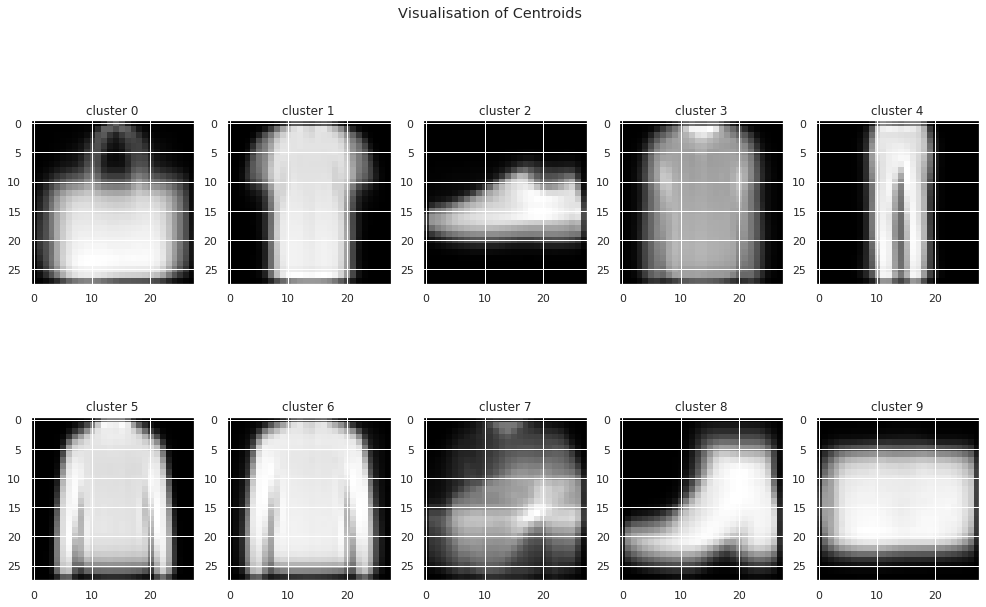

In [ ]:
# initialise figure
fig, ax = plt.subplots(2,5, figsize=(17,10))

# loop through subplots and plot centroid of ith cluster
for i in range(5):

  # plot matrix as gray scale image  
  ax[0,i].imshow(centroids_final[i,:].reshape((28,28)), cmap="gray")
  ax[0,i].set_title('cluster %i' % i)  

  ax[1,i].imshow(centroids_final[i+5,:].reshape((28,28)), cmap="gray")
  ax[1,i].set_title('cluster %i' %(i+5))    

fig.suptitle('Visualisation of Centroids')  

#### Train a kNN calssifier
In this part we will use the labels obtained with a 10-means clustering algorithm and train a kNN-classifier. We will choose k with stratified 5-fold cross validation .

In [ ]:
# Create a base model and fitting
neigh = KNeighborsClassifier()
neigh.fit(X_train, final_kmeans.labels_);

In [ ]:
# predicting for test data
predicted_knn = neigh.predict(X_test)

To compute the accuracy of our classifier we now need to map the clusters to the categories.

I see 3 ways of doing this:

1. Map clusters to clothing category based on the visualisation of the centroid since if the centroid of a cluster for example is a T-shirt, we would want all point close to this centroid (i.e. in the corresponding cluster) to be labeled as T-shirt. The problem arising here is that some of the Images are to clearly identifiable or differentiable from each other.

2. Map clusters to category using the ground truth labels. For each cluster we check which ground truth category is most common among the contained nodes and then assign this category to the cluster. based on the problem with method one, this is the better option even though we could be wrong. 

3. Maximising the trace of the contigency matrix of the k-means labels and their ground truth by permuting the rows and columns.

To improve method 2 slightly, I will combine it with method 1 by check (where the centroids are clearly identifiable as a piece of clothing) that the mapping aligns with the centroid images.

In [ ]:
# find mapping
label_df = pd.DataFrame({'km_cluster':final_kmeans.labels_,'truth':y_train}, columns=['km_cluster', 'truth'])
for i in range(10):
  df = label_df[label_df['km_cluster']==i]
  clothing = df.truth.value_counts().argmax()
  print('cluster',i,'maps to category',clothing)

cluster 0 maps to category 8
cluster 1 maps to category 0
cluster 2 maps to category 7
cluster 3 maps to category 6
cluster 4 maps to category 1
cluster 5 maps to category 4
cluster 6 maps to category 2
cluster 7 maps to category 5
cluster 8 maps to category 9
cluster 9 maps to category 8


Checking this mapping with the images of the centroids we conclude that they align. This mapping means that our classifier won't be able to predict any dresses which is undesirable, but makes the most sense since the centroid of cluster 9 is closest to a bag and none of the images look like a dress. Hence we will continue with this mapping. Here we sacrifice the ability to predict dresses since our algorithm is bad at predicting them anyways.

In [ ]:
# Function for the mapping
def cluster_to_clothing(x):
  if x==0:
    x=8
  elif x==1:
    x=0
  elif x==2:
    x=7
  elif x==3:
    x=6
  elif x==4:
    x=1
  elif x==5:
    x=4
  elif x==6:
    x=2
  elif x==7:
    x=5
  elif x==8:
    x=9
  else:
    x=8
  return(x)
  

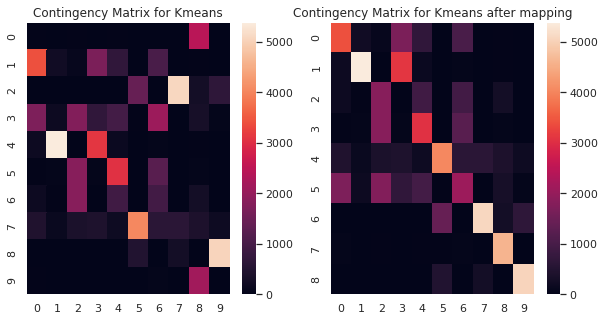

In [ ]:
# using this mapping let us plot the contingency matrices before and after mapping next to each other:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.set_title('Contingency Matrix for Kmeans')
sns.heatmap(contingency_matrix(final_kmeans.labels_, y_train), ax=ax1)

ax2.set_title('Contingency Matrix for Kmeans after mapping')
sns.heatmap(contingency_matrix([cluster_to_clothing(x) for x in final_kmeans.labels_], y_train), ax=ax2)

It looks like we have found a reasonable mapping. The only sacrifice we make is that we can not predict any dresses. 

              precision    recall  f1-score   support

           0       0.48      0.59      0.53      1000
           1       0.58      0.92      0.71      1000
           2       0.47      0.33      0.39      1000
           3       0.00      0.00      0.00      1000
           4       0.50      0.52      0.51      1000
           5       0.55      0.73      0.63      1000
           6       0.29      0.34      0.31      1000
           7       0.69      0.84      0.76      1000
           8       0.96      0.77      0.85      1000
           9       0.88      0.83      0.86      1000

    accuracy                           0.59     10000
   macro avg       0.54      0.59      0.55     10000
weighted avg       0.54      0.59      0.55     10000



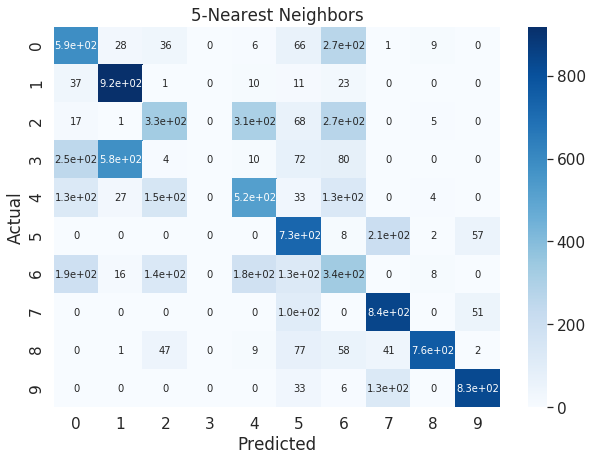

In [ ]:
# compute metrics
print(classification_report(y_test, np.array([cluster_to_clothing(xi) for xi in predicted_knn])))
confusion_matrix_validation = confusion_matrix(y_test, np.array([cluster_to_clothing(xi) for xi in predicted_knn]))

df_cm = pd.DataFrame(confusion_matrix_validation, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
plt.title('5-Nearest Neighbors')
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 10})# font size


The 5-nearest neighbors classifier achieves an accuracy of 59%. Considering the confusion matrix we can observe that the clothing items this classifier is struggling to identify correctly are:


*   predicting dresses as T-shirts and Trousers
*   differentiating between pullovers and coats
* differentiating between T-shirts and Shirts, as well as between Pullovers and Shirts, and also between coats and shirts
* differentiating between Sneakers and Sandals

The algorithm completely fails to identify dresses corectly putting them mostly in clusters with T-shirts and Trousers
Besides this however, this is what we would expect as the above listed groups of items are quite similar to each other on a grayscale image. 

The problem here is the bad mapping from k-means predicted clusters to ground truth labels, which results in a poor accuracy of the knn-Classifier as we are training it on bad data.

Let us take a look at the implementation of method 3. We will use the Hungarian algorithm to maximise the trace of the contingency matrix. and map from cluster to clothing item based on this.

In [ ]:
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.cluster import contingency_matrix
cont_mat = contingency_matrix(final_kmeans.labels_, y_train)
row_ind, col_ind = linear_sum_assignment(-cont_mat)

new_cont_mat = np.zeros((10,10))
for j in range(10):
  for i in range(10):
    new_cont_mat[i,j] = cont_mat[row_ind[i], col_ind[j]]

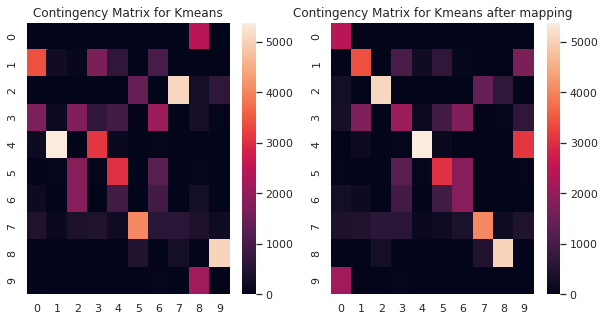

In [ ]:
# using this mapping let us plot the contingency matrices before and after mapping next to each other:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.set_title('Contingency Matrix for Kmeans')
sns.heatmap(contingency_matrix(final_kmeans.labels_, y_train), ax=ax1)

ax2.set_title('Contingency Matrix for Kmeans after mapping')
sns.heatmap(new_cont_mat, ax=ax2)

We observe how the columns and rows of the contingency matrix permuted to maximise the trace.

In [ ]:
# define dictionary for mapping
class_mapping = {'cluster':row_ind, 'classes':col_ind}

In [ ]:
# initialise classifier
neigh_2 = KNeighborsClassifier()
neigh_2.fit(X_train, final_kmeans.labels_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
# predicting for test data
predicted_kn = neigh_2.predict(X_test)

Unfortunately my notebook disconnected whenever I ran the code to predict with the new knn on the test set. We would expect a drop in accuracy but in exchange the algorithm could predict dresses.

### 1.2 Supervised Learning

#### Some functions to use later
1. train the model
2. test the model
3. performance metrics

Note that we need to apply log_softmax() to the outputs in order to feed log probabilities into the NLL loss. This actually corresponds to the Cross Entropy Loss.

In [ ]:
# function to train neural network
def train_net(net, learning_rate = 0.005, batch_size = 138, num_epochs = 30):

  Train = torch.utils.data.TensorDataset(X_train, y_train)
  train_loader = torch.utils.data.DataLoader(Train, batch_size=batch_size)

  # NLL loss
  criterion = nn.NLLLoss()

  # optimiser
  optimiser = torch.optim.SGD(net.parameters(), lr=learning_rate)

  # number of batches
  total_step = len(train_loader)
  # initialising list to store training losses
  loss_values = []

  # looping over epochs
  for epoch in range(num_epochs):

    ###################
    # train the model #
    ###################

    net.train()

    # reset train_loss
    train_loss = 0.0

    # loop over samples and labels stored in the train loader
    for i, (inputs, labels) in enumerate(train_loader, 0):

      labels = labels.type(torch.LongTensor) 
    
      # forward pass
      # apply log_softmax to transform to log probabilities which are needed for NLL loss
      outputs = F.log_softmax(net(inputs))
      loss = criterion(outputs, labels)
          
      # backward and optimise
      optimiser.zero_grad()
      loss.backward()
      optimiser.step()

      # update loss
      train_loss += loss.item()

      # print training statistics
      if (i+1) % 435 == 0:
        print('Epoch [{}/{}] \t Iteration [{}/{}] \t Training Loss: {:.6f}'.format(epoch+1, num_epochs, i+1, total_step, train_loss / total_step))
    
    loss_values.append(train_loss / total_step)
    train_loss = 0.0
  print('Finished Training')
  return loss_values

In [ ]:
 # function to evaluate model on test data
 def test_net(net, size_test_set): 
  Test = torch.utils.data.TensorDataset(X_test, y_test)
  test_loader = torch.utils.data.DataLoader(Test, batch_size=size_test_set)

  net.eval()

  correct = 0
  total = 0
  for inputs, labels in test_loader:
    
    labels = labels.type(torch.LongTensor) 

    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
  return predicted

In [ ]:
# function to show confusion matrix and classification report
def show_metrics(predicted, Title):
  print('Detailed accuracy score',accuracy_score(y_test, np.array(predicted)))
  confusion_matrix_validation = confusion_matrix(y_test, np.array(predicted))

  df_cm = pd.DataFrame(confusion_matrix_validation, columns=np.unique(y_test), index = np.unique(y_test))
  df_cm.index.name = 'Actual'
  df_cm.columns.name = 'Predicted'
  plt.figure(figsize = (10,7))
  plt.title(Title)
  sns.set(font_scale=1.4)#for label size
  sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 10})# font size

  # print metrics
  print(classification_report(y_test, np.array(predicted)))

#### 1.2.1 MLP neural network classifier

In [ ]:
# extract labels so get X and y
y_train = fashion_train.iloc[:,0]
y_test = fashion_test.iloc[:,0]
X_train = fashion_train.drop(fashion_train.columns[0], axis=1)
X_test = fashion_test.drop(fashion_test.columns[0], axis=1)

# prepare data
X_train = torch.from_numpy(X_train.values).float()
y_train = torch.from_numpy(np.array(y_train))
X_test = torch.from_numpy(X_test.values).float()
y_test = torch.from_numpy(np.array(y_test))

In [ ]:
# neural network
input_size = 784  
hidden_size = 100
num_classes = 10
num_epochs = 30

In [ ]:
# define neural network class
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = self.fc4(out)
        return out

In [ ]:
# initialise neural network
net_mlp = NeuralNet(input_size, hidden_size, num_classes)
# train
loss_mlp = train_net(net_mlp)
# test
predicted = test_net(net_mlp, 10000)

Epoch [1/30] 	 Iteration [435/435] 	 Training Loss: 0.816723
Epoch [2/30] 	 Iteration [435/435] 	 Training Loss: 0.472185
Epoch [3/30] 	 Iteration [435/435] 	 Training Loss: 0.420093
Epoch [4/30] 	 Iteration [435/435] 	 Training Loss: 0.388493
Epoch [5/30] 	 Iteration [435/435] 	 Training Loss: 0.367690
Epoch [6/30] 	 Iteration [435/435] 	 Training Loss: 0.351933
Epoch [7/30] 	 Iteration [435/435] 	 Training Loss: 0.339059
Epoch [8/30] 	 Iteration [435/435] 	 Training Loss: 0.328626
Epoch [9/30] 	 Iteration [435/435] 	 Training Loss: 0.319512
Epoch [10/30] 	 Iteration [435/435] 	 Training Loss: 0.311066
Epoch [11/30] 	 Iteration [435/435] 	 Training Loss: 0.303607
Epoch [12/30] 	 Iteration [435/435] 	 Training Loss: 0.296855
Epoch [13/30] 	 Iteration [435/435] 	 Training Loss: 0.290963
Epoch [14/30] 	 Iteration [435/435] 	 Training Loss: 0.286077
Epoch [15/30] 	 Iteration [435/435] 	 Training Loss: 0.280242
Epoch [16/30] 	 Iteration [435/435] 	 Training Loss: 0.275438
Epoch [17/30] 	 I

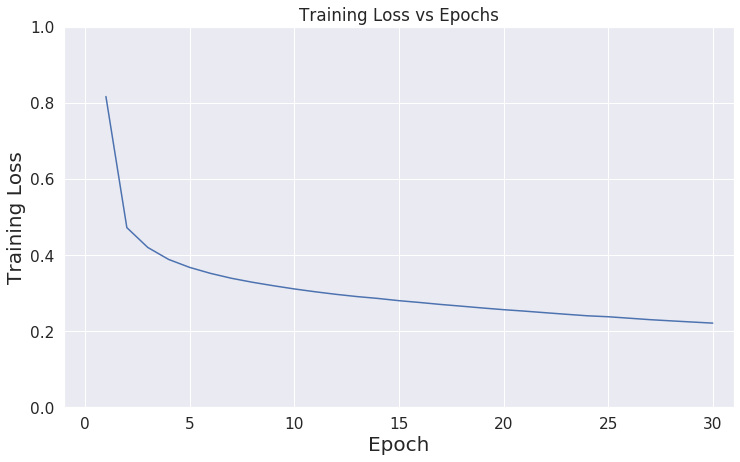

In [ ]:
# plot training loss
plt.figure(figsize=(12,7))
plt.ylim(0,1)
plt.xlim(-1, num_epochs+1)
plt.ylabel('Training Loss', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.title('Training Loss vs Epochs')
plt.plot(np.arange(1,31),loss_mlp)

We can observe that the training loss decreases heavily in the beginning and only slowly in the last epochs suggesting that the model is well trained.

Detailed accuracy score 0.8824
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1000
           1       0.98      0.97      0.98      1000
           2       0.86      0.77      0.81      1000
           3       0.90      0.89      0.90      1000
           4       0.79      0.85      0.82      1000
           5       0.97      0.94      0.96      1000
           6       0.71      0.68      0.70      1000
           7       0.93      0.93      0.93      1000
           8       0.94      0.98      0.96      1000
           9       0.94      0.96      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



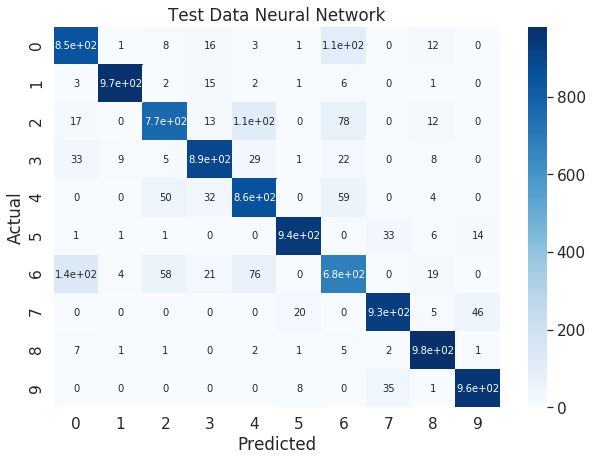

In [ ]:
# test model
predicted_mlp = test_net(net_mlp, 10000)
# compute performance metrics and confusion matrix
show_metrics(predicted_mlp, Title='Test Data Neural Network')

With an accuracy of 88% we find that the neural network is able to predict pretty well. Inspecting the confusion matrix we notice that our neural network still struggles deciding between a Shirt and a T-Shirt as well a Pullover, and between Pullover and Coat. This makes sense, as these items are quite similar. The lowest F1 score, accuracy and precision is obtained for category 6 (Shirt) while the overall highest scores are obtained for category 1 (Trousers). Furthermore, we obtain a averaged recall ( percentage of true positives of all actual positives)  88% and a precision (proportion of true positives of all positve predictions) of 88%.

#### 1.2.2 Convolutional Neural Network Classifier
We will now train a convolutional neural network with the architecture as outlined in the coursework task.

In [ ]:
# first define convolutional neural network class
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, dilation=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, dilation=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        # flatten data
        out = out.reshape(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [ ]:
# extract labels so get X and y
y_train = fashion_train.iloc[:,0]
y_test = fashion_test.iloc[:,0]
X_train = fashion_train.drop(fashion_train.columns[0], axis=1)
X_test = fashion_test.drop(fashion_test.columns[0], axis=1)

# prepare data for neural pytorch
X_train = torch.from_numpy(X_train.values).float()
X_train = X_train.reshape(X_train.size(0),1,28,28)

y_train = torch.from_numpy(np.array(y_train))

X_test = torch.from_numpy(X_test.values).float()
X_test = X_test.reshape(X_test.size(0),1,28,28)

y_test = torch.from_numpy(np.array(y_test))

Epoch [1/30] 	 Iteration [435/435] 	 Training Loss: 0.679763
Epoch [2/30] 	 Iteration [435/435] 	 Training Loss: 0.470801
Epoch [3/30] 	 Iteration [435/435] 	 Training Loss: 0.419664
Epoch [4/30] 	 Iteration [435/435] 	 Training Loss: 0.388571
Epoch [5/30] 	 Iteration [435/435] 	 Training Loss: 0.366422
Epoch [6/30] 	 Iteration [435/435] 	 Training Loss: 0.349304
Epoch [7/30] 	 Iteration [435/435] 	 Training Loss: 0.335736
Epoch [8/30] 	 Iteration [435/435] 	 Training Loss: 0.324375
Epoch [9/30] 	 Iteration [435/435] 	 Training Loss: 0.314523
Epoch [10/30] 	 Iteration [435/435] 	 Training Loss: 0.305550
Epoch [11/30] 	 Iteration [435/435] 	 Training Loss: 0.297520
Epoch [12/30] 	 Iteration [435/435] 	 Training Loss: 0.290295
Epoch [13/30] 	 Iteration [435/435] 	 Training Loss: 0.283458
Epoch [14/30] 	 Iteration [435/435] 	 Training Loss: 0.276809
Epoch [15/30] 	 Iteration [435/435] 	 Training Loss: 0.270849
Epoch [16/30] 	 Iteration [435/435] 	 Training Loss: 0.265356
Epoch [17/30] 	 I

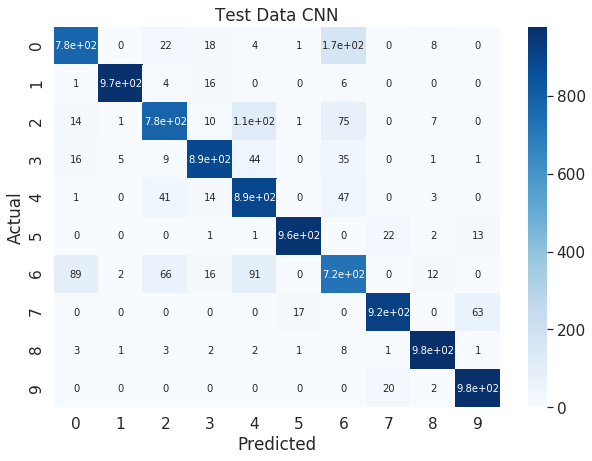

In [ ]:
# initialise
net_cnn=ConvNet()
# train
loss_cnn = train_net(net_cnn)
# test
predicted_cnn=test_net(net_cnn, 10000)
# performance
show_metrics(predicted_cnn, Title='Test Data CNN')

We find that the convolutional neural network achieves slightly higher accuracy and overall performance than the mlp classifier. It is still struggling with differentiating T-shirts and shirts. The averaged accuracy, recall and precision are all 89%.

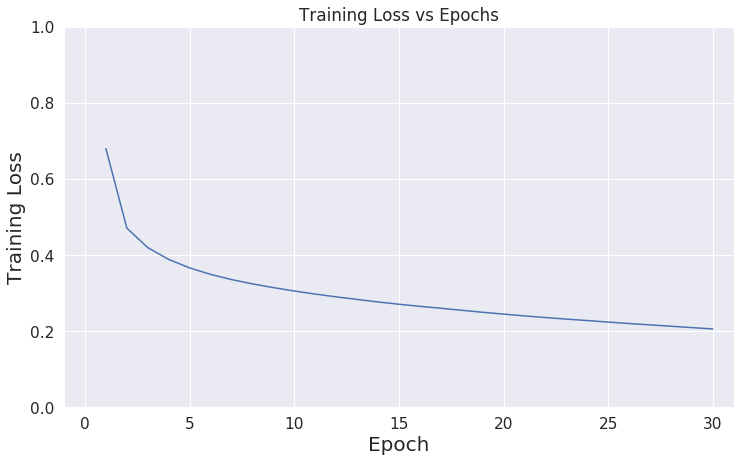

In [ ]:
# plot training loss
plt.figure(figsize=(12,7))
plt.ylim(0,1)
plt.xlim(-1, num_epochs+1)
plt.ylabel('Training Loss', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.title('Training Loss vs Epochs')
plt.plot(np.arange(1,31),loss_cnn)

Again the graph of the training loss indicates that the model is well trained.

#### 1.2.3 Comparison and Optimisation

**Comparison of Performance Between MLP and CNN**

In [ ]:
# number of parameters in models
mlp_total_params = sum(p.numel() for p in net_mlp.parameters())
mlp_trainable_params = sum(p.numel() for p in net_mlp.parameters() if p.requires_grad)

# number of parameters in models
cnn_total_params = sum(p.numel() for p in net_cnn.parameters())
cnn_trainable_params = sum(p.numel() for p in net_cnn.parameters() if p.requires_grad)

print('Total Parameters MLP:', mlp_total_params)
print('Trainable Parameters MLP:', mlp_trainable_params)

print('Total Parameters CNN:', cnn_total_params)
print('Trainable Parameters CNN:', cnn_trainable_params)

Total Parameters MLP: 99710
Trainable Parameters MLP: 99710
Total Parameters CNN: 44426
Trainable Parameters CNN: 44426


We can also calculate this from the architecture of the models:$$(5*5*6+6)+(5*5*6*16+16)+(16*4*4*120+120)+(120*84+84)+(84*10+10) = 4426$$
And $$(784*100+100)+ (100*100+100)+(100*100+100)+(100*10+10)=99710$$

The CNN classifier has less than half the number of parameters than the MLP classifier and still achieves a better performance. This is due to an important characteristic of CNNs, namely weight sharing. While the MLP generates new parameters for each Pixel, the CNN reuses several parameters. Hence CNNs are less memory expensive and les complex. CNNs therefore are more scalable to larger problems than NNs.

Another big advantage of the CNN is that we don't break up the spatial component of the image by flattening the image but take into account surrounding pixels. In general this allows the CNN to learn features which a simple neural network is not able to do. In particular the CNN can detect edges which are an important feature of the image. 

**Comparison of performance between Unsupervised and Supervised**

As displayed above the kNN Classifier obtains only an accuracy of 59% and is not able to predict any dresses. This poor performance is a result of the bat mapping from k-means clusters to clothing categories, indicating that the clustering produced by the k-means algorithm is not great. Regardless of how we create a mapping from clusters to clothing item, we can not obtain a good model. Either we assign the mapping as described in method 2 to maximise the accuracy, but then are not able to predict dresses, or we maximise the trace of the contingency matrix and are able to predict dresses, but scrifice accuracy. This is due to the approach in unsupervised learning. With the supervised classifiers we don't have this struggle and they therefore produce much higher accuracy.

**Optimisation of CNN model architecture**

First let's update the training and testing function slightly so we obtain the training accuracy and take the X_test and y_test as inputs.

In [ ]:
# function to train neural network
def train_net_fold(net, X_train, y_train, learning_rate = 0.005, batch_size = 138, num_epochs = 30):

  Train = torch.utils.data.TensorDataset(X_train, y_train)
  train_loader = torch.utils.data.DataLoader(Train, batch_size=batch_size)

  # loss
  criterion = nn.NLLLoss()

  # optimiser
  optimiser = torch.optim.SGD(net.parameters(), lr=learning_rate)

  # number of batches
  total_step = len(train_loader)
  # initialising list to store training losses
  loss_values = []
  train_accuracy_list = []

  # looping over epochs
  for epoch in range(num_epochs):

    ###################
    # train the model #
    ###################

    net.train()

    # reset train_loss
    train_loss = 0.0
    correct = 0
    total = 0

    # loop over samples and labels stored in the train loader
    for i, (inputs, labels) in enumerate(train_loader, 0):

      labels = labels.type(torch.LongTensor) 
      # resshape to image/matrix
      #inputs = inputs.reshape(inputs.size(0),1,28,28)
      # forward pass
      outputs = F.log_softmax(net(inputs))
      loss = criterion(outputs, labels)
          
      # backward and optimise
      optimiser.zero_grad()
      loss.backward()
      optimiser.step()

      # update loss
      train_loss += loss.item()

      # compute training accuracy
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      

      # print training statistics
      if (i+1) % 435 == 0:
        print('Epoch [{}/{}] \t Iteration [{}/{}] \t Training Loss: {:.6f}'.format(epoch+1, num_epochs, i+1, total_step, train_loss / total_step))
    
    train_accuracy_list.append(correct/total)
    loss_values.append(train_loss / total_step)
    train_loss = 0.0
  print('Finished Training')
  return loss_values, train_accuracy_list

In [ ]:
 # function to evaluate model on test data
 def test_net_fold(net, size_test_set, X_test, y_test): 
  Test = torch.utils.data.TensorDataset(X_test, y_test)
  test_loader = torch.utils.data.DataLoader(Test, batch_size=size_test_set)

  net.eval()

  correct = 0
  total = 0
  for inputs, labels in test_loader:
    
    labels = labels.type(torch.LongTensor) 

    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
  return predicted

Let's now put some thaught in what steps we can take to improve the CNN:

1. Introduce padding. This will ensure that the information around the edge of the image is preserved throughout the application of the Kernel
2. Introduce more convolutional layers leading to more complexity in the model
3. Decrease the size of the kernel, so that the model can learn more detailed features
4. Introduce drop out to keep the model from overfitting and thus make it more generalisable

Lead by these 4 ideas and after trying the drop out rates (0.2,0.25,0.3) I came up with the following architecture:

In [ ]:
# first define convolutional neural network class
class ConvNet_do(nn.Module):
    def __init__(self, drop_rate):
        super(ConvNet_do, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=3, stride=1, dilation=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(6, 6, kernel_size=3, stride=1, dilation=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, dilation=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=5, stride=1, dilation=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout(drop_rate)
        self.fc1 = nn.Linear(16*6*6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        # flatten data
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

The following code will perform the 5-fold cross validation.


In [ ]:
# extract labels so get X and y
target_train = fashion_train.iloc[:,0]
target_test = fashion_test.iloc[:,0]
predictors_train = fashion_train.drop(fashion_train.columns[0], axis=1)
predictors_test = fashion_test.drop(fashion_test.columns[0], axis=1)

In [ ]:


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# counting fold
fold_count = 0

# initialising matrix to store accuracies after each epoch for all folds
#val_accuracy_mat = np.zeros((5,num_epochs))
val_accuracy_list = np.zeros(5)
# initialising matrix to store training losses of each epoch and fold
train_loss_mat = np.zeros((5,num_epochs))
train_accuracy_mat = np.zeros((5,num_epochs))

# perform stratified 5-fold cross validation
for train_index, test_index in kf.split(predictors_train,target_train):
  net_fold = ConvNet_do(drop_rate=0.25)
  X_train, X_val = predictors_train.iloc[train_index], predictors_train.iloc[test_index] 
  y_train, y_val = target_train.iloc[train_index], target_train.iloc[test_index]

  # prepare data for cnn pytorch
  X_train = torch.from_numpy(X_train.values).float()
  X_test = torch.from_numpy(X_val.values).float()

  y_train = torch.from_numpy(np.array(y_train))
  y_test = torch.from_numpy(np.array(y_val))

  # reshape to right dimensions (1 channel and 28x28 matrix)
  X_train = X_train.reshape(X_train.size(0),1,28,28)
  X_test = X_test.reshape(X_test.size(0),1,28,28)

  # train network
  loss_fold, train_acc_fold = train_net_fold(net_fold, X_train, y_train)
  # substituting training losses into loss matrix
  train_loss_mat[fold_count,:] = np.array(loss_fold)
  train_accuracy_mat[fold_count,:]= np.array(train_acc_fold)
  # test network on validation data
  predicted = test_net_fold(net_fold, 12000, X_test, y_test)

  val_accuracy_list[fold_count] = accuracy_score(y_test, predicted)
  
  
  fold_count = fold_count+1
  print(fold_count)

# return averaged validation accuracy and averaged train losses and averaged train accuracy
validation_acc, train_losses, train_acc = val_accuracy_list, np.mean(train_loss_mat, axis=0), np.mean(train_accuracy_mat, axis=0)

Finished Training
1
Finished Training
2
Finished Training
3
Finished Training
4
Finished Training
5


Averaged validation accuracy: 0.90205
With Standard Deviation: 0.00248081527817861


Text(0.5, 0, 'Epoch')

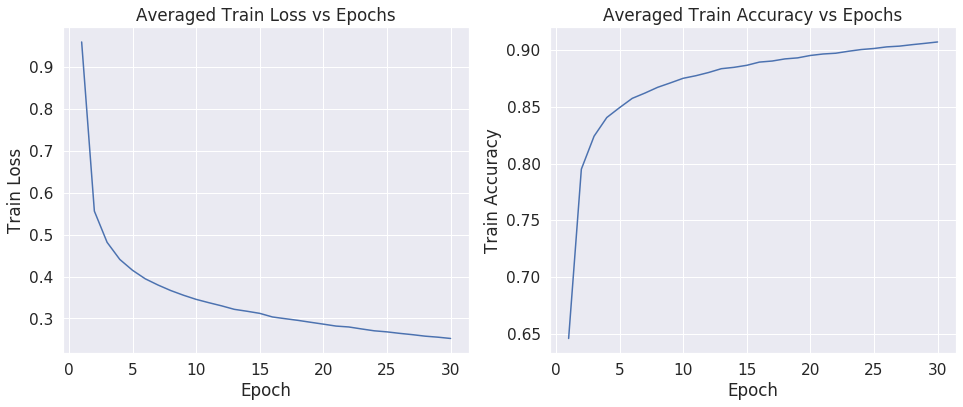

In [ ]:
# check the results of the 5-fold cross validation
print('Averaged validation accuracy:', np.mean(validation_acc))
print('With Standard Deviation:',np.std(validation_acc))


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

ax1.plot(np.arange(1,31), train_losses)
ax1.set_title('Averaged Train Loss vs Epochs')
ax1.set_ylabel('Train Loss')
ax1.set_xlabel('Epoch')
ax2.plot(np.arange(1,31), train_acc)
ax2.set_title('Averaged Train Accuracy vs Epochs')
ax2.set_ylabel('Train Accuracy')
ax2.set_xlabel('Epoch')


We can observe that the final averaged train accuracy takes on a similar value as the validation accuracy providing no evidence for overfitting. We achieve an averaged validation accuracy of above 90% and hence continue with this model architecture. We now train the model on the whole training data and test it on the test data.

Epoch [1/30] 	 Iteration [435/435] 	 Training Loss: 0.897730
Epoch [2/30] 	 Iteration [435/435] 	 Training Loss: 0.529442
Epoch [3/30] 	 Iteration [435/435] 	 Training Loss: 0.458677
Epoch [4/30] 	 Iteration [435/435] 	 Training Loss: 0.422274
Epoch [5/30] 	 Iteration [435/435] 	 Training Loss: 0.399882
Epoch [6/30] 	 Iteration [435/435] 	 Training Loss: 0.379693
Epoch [7/30] 	 Iteration [435/435] 	 Training Loss: 0.366982
Epoch [8/30] 	 Iteration [435/435] 	 Training Loss: 0.354684
Epoch [9/30] 	 Iteration [435/435] 	 Training Loss: 0.344184
Epoch [10/30] 	 Iteration [435/435] 	 Training Loss: 0.333941
Epoch [11/30] 	 Iteration [435/435] 	 Training Loss: 0.329758
Epoch [12/30] 	 Iteration [435/435] 	 Training Loss: 0.318735
Epoch [13/30] 	 Iteration [435/435] 	 Training Loss: 0.315328
Epoch [14/30] 	 Iteration [435/435] 	 Training Loss: 0.309421
Epoch [15/30] 	 Iteration [435/435] 	 Training Loss: 0.304871
Epoch [16/30] 	 Iteration [435/435] 	 Training Loss: 0.299026
Epoch [17/30] 	 I

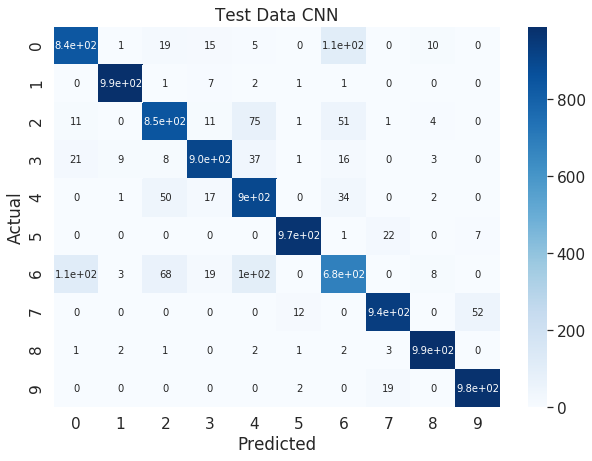

In [ ]:
# extract labels so get X and y
y_train = fashion_train.iloc[:,0]
y_test = fashion_test.iloc[:,0]
X_train = fashion_train.drop(fashion_train.columns[0], axis=1)
X_test = fashion_test.drop(fashion_test.columns[0], axis=1)

# prepare data for neural pytorch
X_train = torch.from_numpy(X_train.values).float()
X_train = X_train.reshape(X_train.size(0),1,28,28)

y_train = torch.from_numpy(np.array(y_train))

X_test = torch.from_numpy(X_test.values).float()
X_test = X_test.reshape(X_test.size(0),1,28,28)

y_test = torch.from_numpy(np.array(y_test))

# initialise
net_final = ConvNet_do(drop_rate=0.25)
# train
loss_final = train_net(net_final)
# test
predicted_final=test_net(net_final, 10000)
# performance
show_metrics(predicted_final, Title='Test Data CNN')

We have managed to increase the accuracy to above 90%. Possible steps to further improve this CNN would be increasing the number of Channels to introduce more complexity in the model and possibly add more convolutional layers. We could also visualise the outputs after each layer and see if we can get any insight on how we could improve the architecture .